In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np


In [2]:
train_dir = r"C:\Users\bisha\Downloads\chest_xray-20250726T110654Z-1-001\chest_xray\train"
valid_dir = r"C:\Users\bisha\Downloads\chest_xray-20250726T110654Z-1-001\chest_xray\val"
test_dir  = r"C:\Users\bisha\Downloads\chest_xray-20250726T110654Z-1-001\chest_xray\test"

train_ds = image_dataset_from_directory(
    train_dir,
    image_size=(100,100),
    batch_size=35,
    color_mode="grayscale",
    label_mode='binary',
    shuffle=True
)

val_ds = image_dataset_from_directory(
    valid_dir,
    image_size=(100,100),
    batch_size=35,
    color_mode="grayscale",
    label_mode='binary',
    shuffle=False
)

test_ds = image_dataset_from_directory(
    test_dir,
    image_size=(100,100),
    batch_size=35,
    color_mode="grayscale",
    label_mode='binary',
    shuffle=False
)


Found 5226 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [3]:
# Normalization + data augmentation
data_augmentation = tf.keras.Sequential([  
    layers.RandomFlip("horizontal_and_vertical"),       # flip augmentation
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)  # slight rotation
])


In [4]:
print("Class Names:", train_ds.class_names)

Class Names: ['NORMAL', 'PNEUMONIA']


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    train_ds
    .map(lambda x, y: ((x / 255.0), y))
    .map(lambda x, y: (data_augmentation(x, training=True), y))
    .cache()
    .shuffle(1000)
    .prefetch(AUTOTUNE)
)
val_ds   = val_ds.map(lambda x, y: (x/255.0, y)).cache().prefetch(AUTOTUNE)
test_ds  = test_ds.map(lambda x, y: (x/255.0, y)).cache().prefetch(AUTOTUNE)


In [6]:
model = models.Sequential([
    layers.Input(shape=(100, 100, 1)),

    layers.Conv2D(32, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),
    

    layers.Conv2D(64, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.5),


    layers.Flatten(),
    layers.Dense(64),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')
])

In [7]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 100, 100, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 100, 100, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 50, 50, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 40000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,560,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,579,585 (9.84 MB)

 Trainable params: 2,579,265 (9.84 MB)

 Non-trainable params: 320 (1.25 KB)

In [8]:
model.compile(
    optimizer='adamW',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [9]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 72s 364ms/step - accuracy: 0.8737 - loss: 0.3026 - val_accuracy: 0.5000 - val_loss: 2.6906
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 53s 354ms/step - accuracy: 0.9321 - loss: 0.1804 - val_accuracy: 0.5000 - val_loss: 3.3142
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 61s 406ms/step - accuracy: 0.9483 - loss: 0.1401 - val_accuracy: 0.5000 - val_loss: 1.7857
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 53s 355ms/step - accuracy: 0.9587 - loss: 0.1163 - val_accuracy: 0.7500 - val_loss: 0.4522
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 45s 298ms/step - accuracy: 0.9579 - loss: 0.1084 - val_accuracy: 0.6250 - val_loss: 0.6502
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 50s 335ms/step - accuracy: 0.9713 - loss: 0.0869 - val_accuracy: 0.5625 - val_loss: 1.6375
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 53s 352ms/step - accuracy: 0.9753 - loss: 0.0710 - val_accuracy: 0.7500 - val_loss: 0.8239


In [10]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.8846 - loss: 0.2940
Test Accuracy: 0.8846, Test Loss: 0.2940


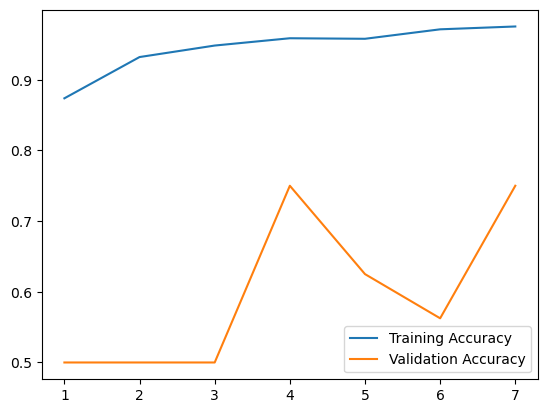

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
epoch_list = list(range(1, len(history.history['accuracy']) + 1))  # values for x axis [1, 2, ..., # of epochs]
plt.plot(epoch_list, history.history['accuracy'], epoch_list, history.history['val_accuracy'])
plt.legend(('Training Accuracy', 'Validation Accuracy'))
plt.show()

In [13]:
#saving the model in file
model.save(r"C:\Users\bisha\OneDrive\Desktop\data science\x_rat_image_model.h5")

In [7]:
from tensorflow.keras.models import load_model

In [7]:
import tensorflow as tf

In [8]:
model = load_model(r"C:\Users\bisha\OneDrive\Desktop\data science\x_rat_image_model.h5")


In [22]:
image=r"C:\Users\bisha\Downloads\chest_xray-20250726T110654Z-1-001\chest_xray\test\NORMAL\IM-0093-0001.jpeg"

In [5]:
def prepare(image):
    img_size=100
    #img_array=cv2.imread(image,cv2.IMREAD_GRAYSCALE)
    img=tf.keras.preprocessing.image.load_img(image, color_mode='grayscale', target_size=(img_size,img_size))
    new_array=tf.keras.preprocessing.image.img_to_array(img)

    return new_array.reshape(-1,img_size,img_size,1)

In [9]:
CATEGORIES = ["NORMAL", "PNEUMONIA"]

In [23]:
prediction=model.predict([prepare(image)/255.0])
print(prediction)
print(round(prediction[0][0]))
print(CATEGORIES[int(round(prediction[0][0]))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
[[0.04751084]]
0
NORMAL


# Pretrained Model

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
img_size=100
 #load previous model
basemodel=VGG16(input_shape=(img_size,img_size,3),include_top=False,weights='imagenet')

#Freeze the layers of the pre trained model
for layer in basemodel.layers:
    layer.trainable=False

In [3]:
#adding of custom layer for classification
x=Flatten()(basemodel.output)
x=Dense(256,activation='relu')(x)
x=Dense(128,activation='relu')(x)
x=Dense(64,activation='relu')(x)
predictions=Dense(1,activation='sigmoid')(x)

model=Model(inputs=basemodel.input,outputs=predictions)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

#compiling the model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

#Define 
train_datagen=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
val_datagen=ImageDataGenerator(rescale=1./255)

In [4]:
train_dir=r"C:\Users\bisha\Downloads\chest_xray-20250726T110654Z-1-001\chest_xray\train"
val_dir=r"C:\Users\bisha\Downloads\chest_xray-20250726T110654Z-1-001\chest_xray\val"

#Create the image generator for training and validation
train_generator=train_datagen.flow_from_directory(train_dir,target_size=(img_size,img_size),batch_size=32,class_mode='binary')
val_generator=val_datagen.flow_from_directory(val_dir,target_size=(img_size,img_size),batch_size=32,class_mode='binary')

Found 5226 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
model.fit(train_generator,epochs=10,validation_data=val_generator,callbacks=[early_stop])

C:\Users\bisha\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 906s 5s/step - accuracy: 0.9200 - loss: 0.2075 - val_accuracy: 0.7500 - val_loss: 0.5864
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 912s 6s/step - accuracy: 0.9422 - loss: 0.1537 - val_accuracy: 0.8125 - val_loss: 0.3856
Epoch 3/10
 77/164 ━━━━━━━━━━━━━━━━━━━━ 8:03 6s/step - accuracy: 0.9520 - loss: 0.1332